# Predicting Cyber-Attacks in IoT Environment

Created by Arwa Alamoudi

---

### Document Sections

- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Description of Dataset Features](#description-of-features)
    - [Types of Operatios](#operations)
- [Data Preprocessing](#data-preprocessing)
- [Data Cleaning & Feature Engineering](#dc_fe)
- [Resampling](#resampling)
- [Modelling, Feature Selection, and Evaluation](#modeling-evlauation)



---

In [ ]:
# Load needed packages into Python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Read dataset
iot = pd.read_csv('./Dataset/mainSimulationAccessTraces.csv')

---

<a id="exploratory-data-analysis"></a>
## Exploratory Data Analysis

This section explores the dataset, its features, their values, and the target column to get better insight about the dataset.

In [3]:
# Dataset dimention
iot.shape

(357952, 13)

In [4]:
# Sample of the first 3 rows
iot.head(3)

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal


This dataset contains information (connections) gathered from 84 IoT devices spread across 21 rooms over 4 sites as shown below:

Site|# of Rooms |Washing Machine|Battery|Thermostat|Smart Door|Smart Phone|Light Controller|Movement Sensor|Thermometer
---| ---| ---| ---| ---| ---| ---| ---| ---| ---
House |6|1|3|1|1|1|6|6|6|
2 Rooms Flat |2|1|1|1|1|1|2|2|2
3 Rooms Flat |3|1|2|1|1|1|3|3|3
Office |10|0|0|1|2|0|10|10|10
Total |21|3|6|4|5|3|21|21|21


In [5]:
# Explore columns names and types
iot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357804 non-null  object
 9   operation                  357952 non-null  object
 10  value                      355902 non-null  object
 11  timestamp                  357952 non-null  int64 
 12  normality                  357952 non-null  object
dtypes: int64(1), object(12)
memory usage: 35.5+ 

So, we only have one numerical variables in the dataset which represnts timestamps of the connections in Unix time.

<a id="description-of-features"></a>
**Description of dataset features:**

1. Source ID: a unique identifier of the source service (device).
2. Source Address: the address of the service from which originates the access.
3. Source Type: the type of the source service.
4. Source Location: the room in which the source service exists.
5. Destination Service Address: the address of the destination service.
6. Destination Service Type: the type of the destination service.
7. Destination Location: the room in which the destination service exists.
8. Accessed Node Address: the address of the accessed service (equivalent to destination service address).
9. Accessed Node Type: the type of the accessed data service in the data of the destination service.
10. Operation: the operation performed between source service and destination service.
11. Value: the value that gets exchange between source service and destination service.
12. Timestamp: a value that represents a timing in which the operation was performed.
13. Normality: the nature of the traffic if it’s normal or not with a detail of the type of attack.

Since most of the features are categorical, let's focus on exploring them more.

In [6]:
# Check the number & percentage of unique values in each feature
frame = pd.concat([iot.dtypes, iot.nunique(), (iot.nunique()/len(iot)*100)], sort=True, axis=1)
frame.columns = ['dtype', 'number of unique', '% unique']
frame.sort_values(by='number of unique')

,dtype,number of unique,% unique
operation,object,5,0.001397
destinationServiceType,object,8,0.002235
normality,object,8,0.002235
sourceType,object,8,0.002235
accessedNodeType,object,12,0.003352
destinationLocation,object,21,0.005867
sourceLocation,object,21,0.005867
sourceID,object,84,0.023467
destinationServiceAddress,object,85,0.023746
sourceAddress,object,89,0.024864


In [7]:
# Describe all objects columns 
iot.describe(include=[np.object])

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,normality
count,357952,357952,357952,357952,357952,357952,357952,357952,357804,357952,355902,357952
unique,84,89,8,21,85,8,21,170,12,5,10623,8
top,washingmachine1,/agent6/washingmachine1,/lightControler,Garage,/agent11/battery4,/sensorService,Garage,/agent11/battery4/charge,/sensorService,read,1,normal
freq,17908,17908,135775,39501,27644,130313,57102,19032,130155,248061,57047,347935


Let's explore the distribution of the values in some features; the ones with the most uniques values. Some of the features presented in a table rather than a chart as the distribution of the values is imbalanced which makes the graph hard to read.

In [8]:
# Explore the distribution of operation 
operation_frq = pd.value_counts(iot.operation).to_frame()
operation = pd.concat([operation_frq, (operation_frq/iot.operation.count()*100)], axis=1)
operation.columns = ['Count', 'Relative Freq.']
operation

,Count,Relative Freq.
read,248061,69.300074
write,109648,30.632040
lockSubtree,148,0.041346
registerService,84,0.023467
subscribe,11,0.003073


<a id="operations"></a>
**Types of Operations:**

1. Read: when an IoT device (the source) **reads** a value from another IoT device (the destination).
2. Write: when an IoT device (the source) **writes** a value in another IoT device (the destination).
   All the features can do both operations.
3. Lock Subtree: when an IoT device **locks** the whole subtrees of the accessed node.
4. Register Service: when an IoT service is **created**.
5. Subscribe: when an IoT device **subscribes** to another IoT device.

In [9]:
# Explore the distribution of source type
sourceType_frq = pd.value_counts(iot.sourceType).to_frame()
sourceType = pd.concat([sourceType_frq, (sourceType_frq/iot.sourceType.count()*100)], axis=1)
sourceType.columns = ['Count', 'Relative Freq.']
sourceType

,Count,Relative Freq.
/lightControler,135775,37.931063
/sensorService,85196,23.800957
/batteryService,81273,22.705000
/washingService,47986,13.405708
/thermostat,5980,1.670615
/movementSensor,1301,0.363457
/doorLockService,335,0.093588
/smartPhone,106,0.029613


In [10]:
# Explore the distribution of destination service type
destinationType_frq = pd.value_counts(iot.destinationServiceType).to_frame()
destinationType = pd.concat([destinationType_frq, (destinationType_frq/iot.destinationServiceType.count()*100)], axis=1)
destinationType.columns = ['Count', 'Relative Freq.']
destinationType

,Count,Relative Freq.
/sensorService,130313,36.405160
/batteryService,129125,36.073272
/movementSensor,93645,26.161329
/washingService,1805,0.504258
/lightControler,1694,0.473248
/doorLockService,1048,0.292777
/thermostat,319,0.089118
/smartPhone,3,0.000838


In [11]:
# Explore the distribution of accessed node type
accessedNode_frq = pd.value_counts(iot.accessedNodeType).to_frame()
accessedNode = pd.concat([accessedNode_frq, (accessedNode_frq/iot.accessedNodeType.count()*100)], axis=1)
accessedNode.columns = ['Count', 'Relative Freq.']
accessedNode

,Count,Relative Freq.
/sensorService,130155,36.376061
/derived/boolean,94725,26.473991
/basic/number,90016,25.157908
/basic/text,42433,11.859286
/thermostat,313,0.087478
/basic/composed,100,0.027948
/lightControler,23,0.006428
/movementSensor,22,0.006149
/batteryService,6,0.001677
/doorLockService,5,0.001397


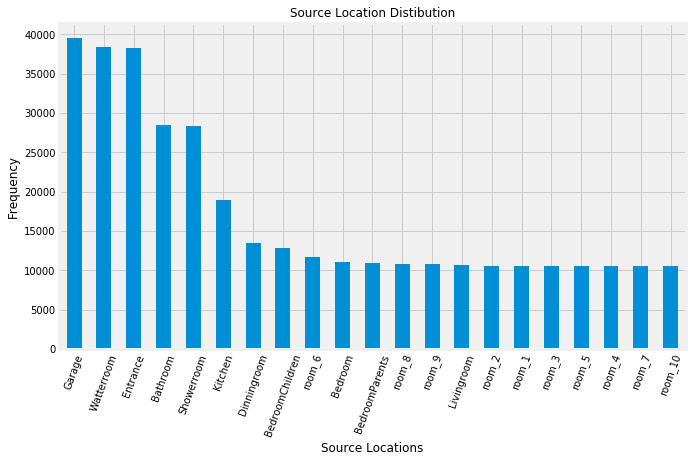

In [12]:
# Explore the distribution of source location
iot.sourceLocation.value_counts().plot(kind='bar', figsize=(10,6));
plt.xticks(rotation=70);
plt.xlabel('Source Locations');
plt.ylabel('Frequency');
plt.title('Source Location Distibution', color = 'black', fontsize = 12);

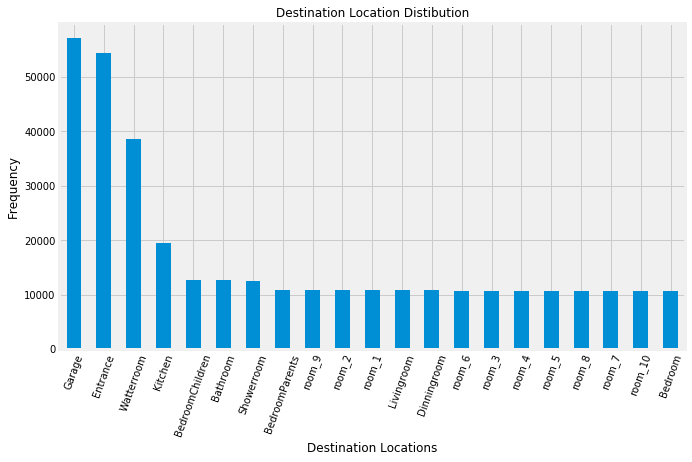

In [13]:
# Explore the distribution of destination location
iot.destinationLocation.value_counts().plot(kind='bar', figsize=(10,6));
plt.xticks(rotation=70);
plt.xlabel('Destination Locations');
plt.ylabel('Frequency');
plt.title('Destination Location Distibution', color = 'black', fontsize = 12);

In [14]:
# Explore the distribution of normality feature
normality_frq = pd.value_counts(iot.normality).to_frame()
normality = pd.concat([normality_frq, (normality_frq/iot.normality.count()*100)], axis=1)
normality.columns = ['Count', 'Relative Freq.']
display(normality)
print("\nTotal anomalous connections:", iot.normality.str.contains('anomalous').sum())
print("Anomalous connections relative frequency:", iot.normality.str.contains('anomalous').sum()\
      /iot.normality.count()*100)

,Count,Relative Freq.
normal,347935,97.201580
anomalous(DoSattack),5780,1.614742
anomalous(scan),1547,0.432181
anomalous(malitiousControl),889,0.248357
anomalous(malitiousOperation),805,0.224890
anomalous(spying),532,0.148623
anomalous(dataProbing),342,0.095544
anomalous(wrongSetUp),122,0.034083



Total anomalous connections: 10017
Anomalous connections relative frequency: 2.7984198998748435


This indicates that ~3% of the connections only are anomalous connections! which is a normal scenario in fraud datasets.

---

<a id="data-preprocessing"></a>
## Data Preprocessing

This section handels the missing values in the dataset and deals with them.

In [15]:
# Number of missing values in each feature
missing = iot.isnull().sum().sort_values(ascending = False).reset_index()
missing.columns = ['Features', 'Missing Values']
missing

,Features,Missing Values
0,value,2050
1,accessedNodeType,148
2,normality,0
3,timestamp,0
4,operation,0
5,accessedNodeAddress,0
6,destinationLocation,0
7,destinationServiceType,0
8,destinationServiceAddress,0
9,sourceLocation,0


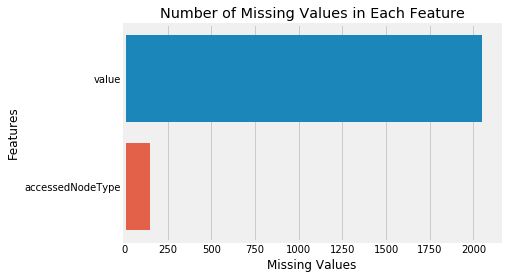

In [16]:
# Visualizing missing values
sns.barplot(x='Missing Values', y='Features', data=missing.head(2));
plt.title('Number of Missing Values in Each Feature');

Before deciding how to deal with the missing values, let's explore these rows to have a better insight.

In [17]:
# Method to assess the null values in dataframe
def assess_NA(data):
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = (((null_sum / len(data.index))*100).round(2)).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[(df_NA.T != 0).any()]
    
    return df_NA

In [18]:
# Check if rows with missing accessed node type & values are anomalous connections
anomalous = iot[iot.normality.str.contains('anomalous')]
df_with_any_null_values = anomalous[anomalous.columns[anomalous.isnull().any()].tolist()]
assess_NA(df_with_any_null_values)

,Number of NA,Percent NA
value,2044,20.41
accessedNodeType,148,1.48


Number of missing values in accessed node types are 148, all of which represent anomalous connections. Also, the value feature has 2050 missing values, 2044 of them are related to anomalous connections, equivalent to 20% of the total number of anomalous connections in the dataset. Thus, deleting these rows are not a possible option here as it may cause lose of valuable data.

Before deciding how to deal with the missing values, let's explore these rows to have a better insight.

In [19]:
# Check if the missing values in accessedNodeType are in the same rows of value feature
anomalous[(anomalous.accessedNodeType.isnull())&(anomalous.value.isnull())].shape[0]

148

### 1. Dealing with accessed node type missing values

In the dataset, there is accessed node address and accessed node type. These two features are relevant to each other in which the former describes the address of accessed node and the later describes the type of that accessed node. So let's have a look at the relation between these two features to get a better insight on how to impute the missing values in accessed node type column.

In [20]:
# Check the address of the accessed nodes that have missing types
iot[iot.accessedNodeType.isnull()].accessedNodeAddress.unique()

array(['/agent5/battery2/charging', '/agent4/battery3/charging'],
      dtype=object)

In [21]:
# Check the types of these two addresses in the complete dataset 
iot[(iot.accessedNodeAddress == '/agent5/battery2/charging')|\
    (iot.accessedNodeAddress == '/agent4/battery3/charging')].accessedNodeType.value_counts()

/basic/text    10705
Name: accessedNodeType, dtype: int64

This result shows that there is only one type for these two addresses in the complete dataset which is *'/basic/text'*. So let's impute the missing values in accessed node type column using the **the most frequent** or in this case the only one type based on these addresses types. 

In [22]:
# Using fillna to fill in all accessed node type missing values with '/basic/text' type
iot.accessedNodeType.fillna(value='/basic/text', inplace=True)

In [23]:
# Verify the number of missing values in accessed node type
iot.accessedNodeType.isnull().sum()

0

### 2. Dealing with value column missing data

In [24]:
# Number of unique values in value column
iot.value.nunique()

10623

In [25]:
# Number of unique values for normal connections
iot[iot.normality.str.contains('normal')].value.nunique()

10616

In [26]:
# Unique values for anomalous connections
iot[iot.normality.str.contains('anomalous')].value.unique()

array(['1', '19.9497', '5.1', '0', '3.24', 'twenty', '4.03', '4.12', nan,
       'false', '5', 'true', '0.0', '10', '19.881', '19.8819'],
      dtype=object)

In [27]:
# Check the value counts of the value column
iot.value.value_counts()

1                    57047
0                    50282
false                25966
true                 14460
10                    9635
                     ...  
1.521216841986E12        1
19.7878                  1
1.521218776648E12        1
1.521223732901E12        1
1.52122153002E12         1
Name: value, Length: 10623, dtype: int64

The value column contains 10623 unique values, 10616 related to normal connections and 15 unique values related to anomalous connetions. Also, the values in this column are diverse; decimal, integer, boolean, none, and even string. From initial exploration, there was no clear relatioship between these values and the target (normality) column. It might need a deep investigation and rough cleaning process to check if such a relation exist or not; however, considering the time limit for working in this project, I will drop this column from the dataset.

In [28]:
# Drop on value column from iot dataset, but before keep a copy of original one
iot_value = iot.copy()
iot.drop('value', axis=1, inplace=True)

---

<a id="dc_fe"></a>
## Data Cleaning & Features Engineering

In this section, I visit the columns and try to reenginner them based on my understading of the dataset after reading authors descriptions of the data. 

The main actions are as follow:

1. Tranform target column "normality" to binary class.
2. Split the addresses columns into two columns 'address' and 'agent'.
3. Remove '/' from the beginning of some columns.
4. Drop identical and duplicated columns.
5. Transform categorical variables into numerical variables.

In [29]:
# At this point, we don't have any missing values
iot.isnull().sum()

sourceID                     0
sourceAddress                0
sourceType                   0
sourceLocation               0
destinationServiceAddress    0
destinationServiceType       0
destinationLocation          0
accessedNodeAddress          0
accessedNodeType             0
operation                    0
timestamp                    0
normality                    0
dtype: int64

### 1. Tranform target column

In [30]:
# Create binary target column
iot['normality_binary'] = np.where(iot.normality.str.contains('anomalous'), 1, 0)
iot.sample(3)

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,timestamp,normality,normality_binary
96163,lightcontrol27,/agent27/lightcontrol27,/lightControler,room_8,/agent27/movement27,/movementSensor,room_8,/agent27/movement27/movement,/derived/boolean,read,1520058447748,normal,0
48875,washingmachine1,/agent6/washingmachine1,/washingService,Bathroom,/agent5/battery2,/batteryService,Garage,/agent5/battery2/charge,/basic/number,write,1520045152321,normal,0
201952,tempin22,/agent22/tempin22,/sensorService,room_3,/agent22/tempin22,/sensorService,room_3,/agent22/tempin22,/sensorService,write,1520084821148,normal,0


In [31]:
# Check if mapping done correctly
iot[iot.normality_binary == 1].normality_binary.count()

10017

In [32]:
# Drop normality column
iot.drop('normality', axis=1, inplace=True)

### 2. Split the addresses columns

In [33]:
# Function to split the addresses columns into two columns, agent and address.
def split_address(cols):
    for col in cols:
        iot[col[:-7]+'Agent']=iot[col].str.split('/',2, expand=True)[1]
        iot[col]=iot[col].str.split('/',2, expand=True)[2]

In [34]:
# Create a list of address columns names and send it to split address function
adresses = ['sourceAddress','accessedNodeAddress','destinationServiceAddress']
split_address(adresses)

### 3. Remove '/' from some columns

In [35]:
# Remove '/' from the begining of sourceType, destinationServiceType, and accessedNodeType
def remove_slash(cols): 
    for col in cols:
        iot[col] = iot[col].map(lambda x: x.lstrip('/'))

In [36]:
# Let's call the function 
types = ['sourceType','destinationServiceType','accessedNodeType']
remove_slash(types)

### 4. Remove Identical and Duplicated Columns

In [37]:
# Compare sourceID and sourceAddress columns
iot['sourceAddress_comparison'] = np.where(iot["sourceID"] == iot["sourceAddress"], True, False)

In [38]:
# Check the number of true values
iot['sourceAddress_comparison'].value_counts()

True    357952
Name: sourceAddress_comparison, dtype: int64

In [39]:
# The columns are match, drop sourceID and sourceAddress_comparison
iot.drop('sourceID', axis=1, inplace=True)
iot.drop('sourceAddress_comparison', axis=1, inplace=True)

In [40]:
# Compare destinationServiceAgent and accessedNodeAgent columns 
iot['destination_accessed'] = np.where(iot["destinationServiceAgent"] == iot["accessedNodeAgent"], True, False)
iot['destination_accessed'].value_counts()

True    357952
Name: destination_accessed, dtype: int64

In [41]:
# The columns are match, drop accessedNodeAgent and destination_accessed
iot.drop('accessedNodeAgent', axis=1, inplace=True)
iot.drop('destination_accessed', axis=1, inplace=True)

Based on my understading of the dataset, there are 21 rooms represented by 'Location' in the dataset. Also, there are agents that represent the root address of a service. I will investigate if agent is equivalent to room; I mean they always have the same pair of values in the whole dataset. If so, I will remove duplicate columns.

In [42]:
# Number of unique values in locations and agents columns
print("Source location unique values: ",iot.sourceLocation.nunique())
print("Source agent unique values: ",iot.sourceAgent.nunique())
print("Destination location unique values: ",iot.destinationLocation.nunique())
print("Destination agent unique values: ",iot.destinationServiceAgent.nunique())

Source location unique values:  21
Source agent unique values:  21
Destination location unique values:  21
Destination agent unique values:  21


In [43]:
# Check if source location and source agent are duplicated
iot.duplicated(['sourceLocation','sourceAgent'],keep=False).sum()

357952

In [44]:
# Check if destination location and destination agent are duplicated
iot.duplicated(['destinationLocation','destinationServiceAgent'],keep=False).sum()

357952

The results are equilavent to the number of rows in the complete dataset, so they are duplicated.

In [45]:
# Drop source agent and destination agent columns
iot.drop('sourceAgent', axis=1, inplace=True)
iot.drop('destinationServiceAgent', axis=1, inplace=True)

Now, I will try to reduce the number of unique variables in the 'accessedNodeAddress' column by exploring its relationship with 'accessedNodeType' column.

In [46]:
# Remove all numbers (devices numbers) from accessedNodeAddress
iot['temp_accessedNodeAddress'] = iot['accessedNodeAddress'].str.replace('\d+', '')

In [47]:
# Check if accessed node address without numbers column and accessedNodeType column are duplicated
iot.duplicated(['accessedNodeType','temp_accessedNodeAddress'],keep=False).sum()

357952

We have 84 IoT devices of 8 types in the dataset, as shown, it's always the same relationship between the type of device in 'accessedNodeAddress' and the type of connection this device does in 'accessedNodeType', for example: movement4 device and movementSensor type. The difference and what makes the unique values large is the 84 devices, although they have the same types and relashipships with 'accessedNodeType'.

So I will remove what's after '/' in 'accessedNodeAddress' columns to reduce the number of unique values, as it can always be described by 'accessedNodeType' columns.

In [48]:
# Remove all characters after '/' in accessedNodeAddress and drop the temporary coulmn
iot['accessedNodeAddress']=iot['accessedNodeAddress'].str.split('/').str[0]
iot.drop('temp_accessedNodeAddress', axis=1, inplace=True)

In [49]:
# Check if destinationServiceAddress is equal to accessedNodeAddress
iot[iot.destinationServiceAddress == iot.accessedNodeAddress].shape[0]

357952

In [50]:
# The are equal, drop destinationServiceAddress column
iot.drop('destinationServiceAddress', axis=1, inplace=True)

### 5. Tranformation

In [51]:
# Tranform all categorial variables into numberical variables
for col in iot.columns:
    if iot[col].dtype == np.object:
        iot = pd.get_dummies(iot, columns=[col])

In [52]:
# Shape of the dataset
iot.shape

(357952, 245)

---

## Some Visualizations

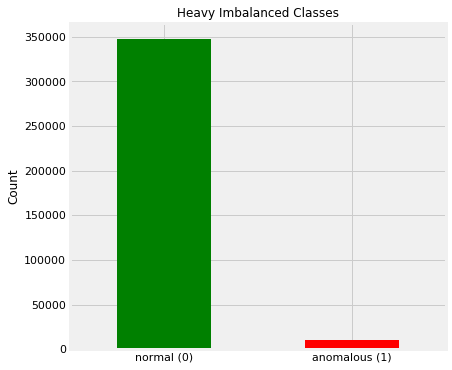

In [53]:
# Bar chart of binary class distribution
fig, ax2 = plt.subplots()
iot.normality_binary.value_counts().plot(kind='bar', ax=ax2, figsize=(6,6), fontsize=11, color=['green', 'red']);
plt.xticks(rotation=0);
ax2.set_ylabel('Count')
ax2.set_title('Heavy Imbalanced Classes', color = 'black', fontsize = 12);
ax2.set_xticklabels(('normal (0)', 'anomalous (1)'));

It's clear by now and from the figure above that this dataset suffers from heavey imbalaced classes. The normal connections cover 97.2% which is far outweight the anomalous connections. We can't train the model on this dataset as it will result in a biased model; we may have high accuracy score as the normal class was the dominant class in the dataset.

For this reason, I will do resampling for the dataset before trainng and testing it.

---

<a id="resampling"></a>
## Resampling

In this section, the following resampling technique will be applied: Synthetic Minority Oversampling (SMOTE).

In [54]:
# Function to print information about normality feature before resampling
def print_before (name):
    print("Before {}, counts of label '0' (normal): {}".format(name, sum(iot.normality_binary == 0))) 
    print("Before {}, counts of label '1' (anomalous): {} \n".format(name, sum(iot.normality_binary == 1))) 

In [55]:
# Function to print information about normality feature after resampling
def print_after (name, y, df):
    print("After {}, counts of label '0' (normal): {}".format(name, sum(y == 0))) 
    print("After {}, counts of label '1' (anomalous): {} \n".format(name, sum(y == 1))) 
    print("Dataset shape after {}: {}".format(name, df.shape))

### 1. Synthetic Minority Oversampling (SMOTE)

In [56]:
# Check the number of normal and anomalous connections before resampling
print_before('SMOTE oversampling') 

Before SMOTE oversampling, counts of label '0' (normal): 347935
Before SMOTE oversampling, counts of label '1' (anomalous): 10017 



In [57]:
# Import required library
from imblearn.over_sampling import SMOTE

# Spearate the target from the predictors
X = iot.loc[:, iot.columns != 'normality_binary']
y = iot.normality_binary

# Instantiate SMOTE object
sm = SMOTE(sampling_strategy='minority', random_state = 2)

# Fit and apply the resample 
X_sm, y_sm = sm.fit_resample(X, y)

In [58]:
# Concat both dataframes
iot_sm = pd.concat([X_sm, y_sm], axis=1)

In [59]:
# Check normality classes numbers and new dataset shape 
print_after('SMOTE oversampling', y_sm, iot_sm)

After SMOTE oversampling, counts of label '0' (normal): 347935
After SMOTE oversampling, counts of label '1' (anomalous): 347935 

Dataset shape after SMOTE oversampling: (695870, 245)


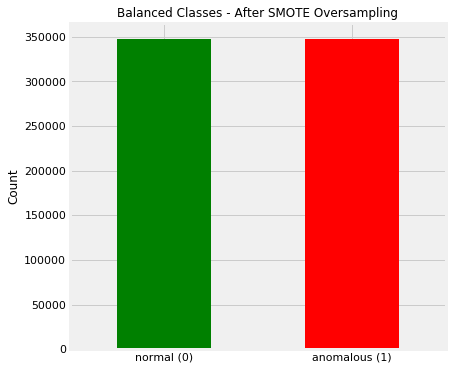

In [60]:
# Bar chart of binary class distribution after SMOTE oversampling
fig, ax2 = plt.subplots()
iot_sm.normality_binary.value_counts().plot(kind='bar', ax=ax2, figsize=(6,6), fontsize=11, color=['g', 'r']);
plt.xticks(rotation=0);
ax2.set_ylabel('Count')
ax2.set_title('Balanced Classes - After SMOTE Oversampling', color = 'black', fontsize = 12);
ax2.set_xticklabels(('normal (0)', 'anomalous (1)'));

---

<a id="modeling-evlauation"></a>
## Modelling, Feature Selection, and Evaluation

In this section, random forest algorithm has been applies to SMOTE dataset. Before that Area Under Curve (AUC) evaluation metric was used to help better tune algorithms parameters.

### Functions

In [61]:
# Import required libraries & setting options
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
precision_recall_fscore_support, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

pd.set_option('display.max_columns', None)

In [62]:
# Print original, train, and test sets
def print_after_split(sample_type, X, X_train, X_test, y_train, y_test):
    print("Original {} dataset shape: {}".format(sample_type, X.shape))
    print("X train {} dataset shape: {}".format(sample_type, X_train.shape))
    print("X test {} dataset shape: {}".format(sample_type, X_test.shape))
    print("y train {} dataset shape: {}".format(sample_type, y_train.shape))
    print("y test {} dataset shape: {}".format(sample_type, y_test.shape))

In [63]:
# Create a dataframe with all evaluation metrics
def create_df(y_test, y_preds, classifier):
    accuracy = accuracy_score(y_test, y_preds)
    Missclassification= 1 - accuracy
    cm = confusion_matrix(y_test, y_preds)
    TN = cm[0, 0]
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    report = classification_report(y_test, y_preds,output_dict=True)
    precision_0 = report['0']['precision']
    precision_1 = report['1']['precision']
    recall_0 = report['0']['recall']
    recall_1 = report['1']['recall']
    f1_score_0 = report['0']['f1-score']
    f1_score_1 = report['1']['f1-score']
    classification_measures = [accuracy, Missclassification, TP, TN, FP, FN, precision_0, precision_1,\
                              recall_0, recall_1, f1_score_0, f1_score_1]
    m = np.asarray(classification_measures)
    if classifier == 't':
        df_t[str(f) + " Features " + str(d)] = m
        return df_t
    elif classifier == 'l':
        df_l[str(i) + " Features"] = m
        return df_l
    else:
        df_f[str(f) + " Features "] = m
        return df_f     

In [64]:
def confusion_plot(y_preds, y_test, text):
    # converting the y_test, y_pred into an array assigned to variable "cm" 
    cm = np.array(confusion_matrix(y_test, y_preds))
    cm_lr = pd.DataFrame(cm, index=['actual_normal', 'actual_anomalous'],
                             columns=['predicted_normal',
                                      'predicted_anomolous']); cm_lr
    plt.title('Confusion Matrix for\n SMOTE Oversampling Dataset\n {}'.format(text), fontweight='bold', y=1.02)
    sns.heatmap(pd.DataFrame(cm_lr), annot=True, square=True, linewidth=0.5, 
            fmt='', center=0, cmap="YlGnBu")
    plt.yticks(rotation=0);
    plt.show();

In [65]:
# Function to evaluate the performance using AUC as the evaluation metric
def evaluation (X_train,y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_preds = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

In [66]:
# This function helps determine the maximum number of features to be added to the model
def max_feature(X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(max_features=n)
    evaluation(X_train,y_train, X_test, y_test, model)

In [67]:
# This function helps determine the maximum number of depth to be defined in the model
def max_depth (X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(max_depth=n, n_jobs=-1)
    evaluation(X_train,y_train, X_test, y_test, model)

In [68]:
# This function helps determine the minimum number of leaves to be defined in the model
def min_samples_leaf (X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(min_samples_leaf=n)
    evaluation(X_train,y_train, X_test, y_test, model) 

In [69]:
# This function helps determine the minimum number of splits to be defined in the model
def min_samples_split (X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(min_samples_split=n)
    evaluation(X_train,y_train, X_test, y_test, model) 

In [70]:
# Method to help determine the number of trees
def n_trees (X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    evaluation(X_train,y_train, X_test, y_test, model)

In [71]:
# Plot the AUC scores for training and testing sets
def plotting (values, text):
    line1, = plt.plot(values, train_results, "b", label="Train AUC")
    line2, = plt.plot(values, test_results, "r", label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel(text)
    plt.show(); 

In [72]:
# Function to determine the features importance scores
def feature_imort(model, X_train, y_train):
    feature_importances = model.feature_importances_
    features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
    features_df.sort_values('Importance Score', inplace=True, ascending=False)
    display(features_df.head(f))
    print("Number of features {}".format(f))
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc')
    print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

In [73]:
# Function to perform random forest
def random_forest(X_train,y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=e, max_depth=d, max_features=f) 
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("roc_auc train: ",roc_auc)
    y_preds = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("roc_auc test: ",roc_auc)
    feature_imort(model, X_train, y_train)
    dataframe = create_df(y_test, y_preds, 'f')
    return dataframe, y_preds

### Synthetic Minority Oversampling (SMOTE) & Random Forest

In [74]:
# Split the timestamp from other categorical variables
X_sm = X_sm.loc[:, X_sm.columns != 'timestamp']

# split dataset into train and test sets
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=1)

In [75]:
# Printing after spliting 
print_after_split("SMOTE oversampled", X_sm, X_sm_train, X_sm_test, y_sm_train, y_sm_test)

Original SMOTE oversampled dataset shape: (695870, 243)
X train SMOTE oversampled dataset shape: (487109, 243)
X test SMOTE oversampled dataset shape: (208761, 243)
y train SMOTE oversampled dataset shape: (487109,)
y test SMOTE oversampled dataset shape: (208761,)


In [76]:
print("The baseline or prevalance in y test for SMOTE dataset is:", 1 - y_sm_test.mean())

The baseline or prevalance in y test for SMOTE dataset is: 0.49999281474988144


In [77]:
# Determine the maximum number of features, this part takes a very long time to run.
#max_features = list(range(1,X_sm_train.shape[1]))
#train_results = []
#test_results = []
#for n in max_features:
    #max_feature(X_sm_train,y_sm_train, X_sm_test, y_sm_test)

#plotting(max_features, 'max features')

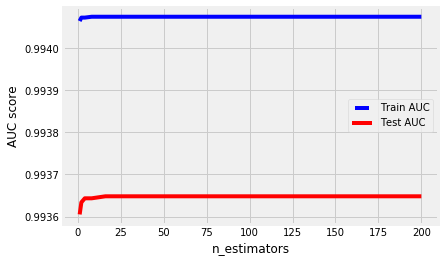

In [78]:
# Determine the maximum number of estimators (trees)
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for n in n_estimators:
    n_trees(X_sm_train,y_sm_train, X_sm_test, y_sm_test)

plotting(n_estimators,'n_estimators' )

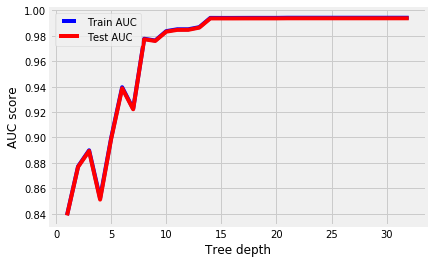

In [79]:
# Determining the maximum depth
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for n in max_depths:
    max_depth(X_sm_train, y_sm_train, X_sm_test, y_sm_test)

plotting(max_depths,'Tree depth' )

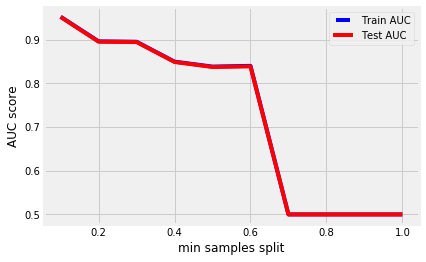

In [80]:
# Determine the minimum number of splits
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for n in min_samples_splits:
    min_samples_split(X_sm_train,y_sm_train, X_sm_test, y_sm_test)

plotting(min_samples_splits,'min samples split' )

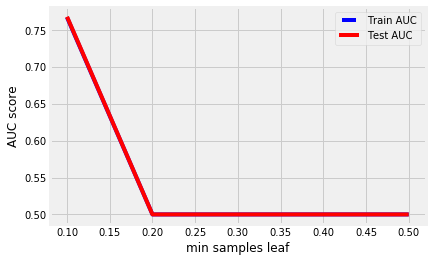

In [81]:
# Determine the minimum number of leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for n in min_samples_leafs:
    min_samples_leaf(X_sm_train,y_sm_train, X_sm_test, y_sm_test)

plotting(min_samples_leafs,'min samples leaf')

Based on the results obtained, the following parameters will be considered:

1. max_feature = 15
2. n_estimators = 25
3. tree_depth = 10
3. min_samples_split = 2 (the default value)
4. min_samples_leaf = 1 (the default value)

In [87]:
# Running the algorithm based on specified parameters
df_f = pd.DataFrame(index=['Accuracy', 'Missclassification', 'TP', 'TN', 'FP', 'FN', 'Precision 0',\
                                    'Precision 1', 'Recall 0', 'Recall 1','F1-score 0', 'F1-score 1'])
e, f, d = 25, 15, 10

features = X_sm_train.columns
df_sm_fresult, y_preds = random_forest(X_sm_train,y_sm_train, X_sm_test, y_sm_test)
df_sm_fresult

roc_auc train:  0.9835293263751835
roc_auc test:  0.9830811895622067


,Features,Importance Score
113,destinationServiceType_batteryService,0.078009
227,accessedNodeType_basic/number,0.076756
11,sourceAddress_heatingcontrol1,0.067247
90,sourceType_thermostat,0.061175
178,accessedNodeAddress_movement1,0.048838
117,destinationServiceType_sensorService,0.041588
123,destinationLocation_BedroomChildren,0.040281
228,accessedNodeType_basic/text,0.039463
225,accessedNodeAddress_washingmachine3,0.036129
234,accessedNodeType_sensorService,0.035943


Number of features 15
CV AUC [0.99373936 0.99359864 0.99413613 0.99385678 0.99586375], Average AUC 0.9942389319885603


,15 Features
Accuracy,0.983081
Missclassification,0.016919
TP,102191.000000
TN,103038.000000
FP,1341.000000
FN,2191.000000
Precision 0,0.979179
Precision 1,0.987047
Recall 0,0.987153
Recall 1,0.979010


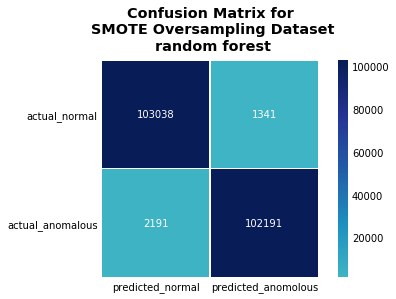

In [88]:
# Plot confusion matrix
confusion_plot(y_preds, y_sm_test, 'random forest')

- GA Final Project - Predicting Cybe-Attacks in IoT Environments
- Work done by Arwa Alamoudi - 11/5/2020